/tmp/ipykernel_20394/2514524358.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


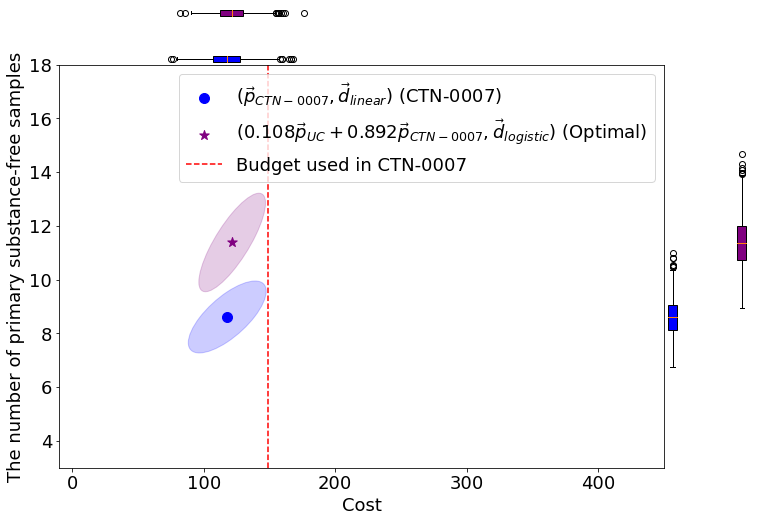

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Ensure Matplotlib does not use LaTeX
plt.rcParams['text.usetex'] = False

def plot_ellipse(ax, x, y, label, color, marker):
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*2*1.96, height=lambda_[1]*2*1.96, 
                  angle=np.rad2deg(np.arccos(v[0, 0])), color=color, alpha=0.2)
    ax.add_patch(ell)
    ax.scatter(np.mean(x), np.mean(y), color=color, s=100, label=label, marker=marker)

df_linear = pd.read_csv('linear.csv')
df_logistic = pd.read_csv('logistic.csv')
policy_name_list = np.unique(df_linear['policy'])
policy_name_plots_list = [policy_name_list[0], policy_name_list[108]]
legend_name_list = [
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{linear})$ (CTN-0007)', 
    r'$(0.108\vec{p}_{UC}+0.892\vec{p}_{CTN-0007}, \vec{d}_{logistic})$ (Optimal)'
]

color_list = ['blue', 'purple']
colors = dict(zip(policy_name_plots_list, color_list))

marker_list = ['o', '*']
markers = dict(zip(policy_name_plots_list, marker_list))

def format_policy_name(policy_name):
    components = policy_name.split(", ")
    formatted_components = []
    
    for component in components:
        key, value = component.split(": ")
        formatted_percentage = float(value) * 100
        formatted_components.append(f"{key} ({formatted_percentage:.2f}%)")
        
    return ", ".join(formatted_components)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])  # x-position, y-position, width, height

data_incentives = []
data_outcomes = []

i = 0
for policy_name in policy_name_plots_list:
    legend_name = legend_name_list[i]
    if i == 0:
        df_policy = df_linear[df_linear['policy'] == policy_name]
    else:
        df_policy = df_logistic[df_logistic['policy'] == policy_name]
    incentives_data = df_policy[df_policy['reward name'] == 'incentives']['discounted reward'].values
    outcome_data = df_policy[df_policy['reward name'] == 'primary substance-free']['discounted reward'].values
    
    data_incentives.append(incentives_data)
    data_outcomes.append(outcome_data)
    
    plot_ellipse(ax, incentives_data, outcome_data, legend_name, colors.get(policy_name, 'red'), markers.get(policy_name, 'o'))
    i += 1
del(i)

all_incentives = np.concatenate(data_incentives)
all_outcomes = np.concatenate(data_outcomes)
buffer_percentage = 0.05
xmin = np.min(all_incentives) - buffer_percentage * np.ptp(all_incentives)
xmax = np.max(all_incentives) + buffer_percentage * np.ptp(all_incentives)
ymin = np.min(all_outcomes) - buffer_percentage * np.ptp(all_outcomes)
ymax = np.max(all_outcomes) + buffer_percentage * np.ptp(all_outcomes)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax_xbox = fig.add_axes([0.1, 0.8, 0.7, 0.1])
positions_x = np.linspace(1, 5, len(policy_name_plots_list))
bp_x = ax_xbox.boxplot(data_incentives, vert=False, patch_artist=True, positions=positions_x)
ax_xbox.set_xlim(xmin, xmax)
ax_xbox.axis('off')
for patch, color in zip(bp_x['boxes'], color_list):
    patch.set_facecolor(color)

ax_ybox = fig.add_axes([0.8, 0.1, 0.1, 0.7])
positions_y = np.linspace(1, 5, len(policy_name_plots_list))
bp_y = ax_ybox.boxplot(data_outcomes, patch_artist=True, positions=positions_y)
ax_ybox.set_ylim(ymin, ymax)
ax_ybox.axis('off')
for patch, color in zip(bp_y['boxes'], color_list):
    patch.set_facecolor(color)

ax.axvline(x=149, color='red', linestyle='--', linewidth=1.5, label='Budget used in CTN-0007')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.set_xlim(-10, 450)
ax.set_ylim(3, 18)
ax_xbox.set_xlim(-10, 450)
ax_ybox.set_ylim(3, 18)

ax.set_xlabel('Cost', fontsize=18)
ax.set_ylabel('The number of primary substance-free samples', fontsize=18)
plt.tight_layout()
ax.legend(fontsize=18, loc='best')

plt.savefig("comparison_optimal_schemas.jpg", dpi=300, bbox_inches='tight')
plt.show()
